# Modelling with Linear Regression
ML is built on recurring patterns. One of them is the __linear model__.

We'll cover
* simple LR
* Robust LR
* Hierarchical LR
* Polynomial LR
* Multiple LR
* Interactions
* Variable variance

In [10]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Simple Linear Regression
Many problems can be stated in the form: we have a variable $x$ and we want to predict from that $y$. The variables are paried up like $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$.

In the simple LR model, bothe x and y and uni-dimensional continuous random variables. $y$ is known as a dependent, predicted or outcome variable, $x$ is the independent, predictor or input variable.

if $x$ is multidimensional (i.e. represetned by a matrix rather than a 1d list), then we have multiple LR.

### Machine Learning
An umbrella term for methods for automatically learning patterns from data, then take decisions. ML has a deep dependency on stats. Some jargon busting:

a regression problem is an example of __supervised learning__. Supervised beacuse we know the X-Y pairs - in effect we know the answer and are trying to generalise rules in the dataset.

__Features__ are put in place of variables.

### Linear regression models
THe familiar equation $y_u = \alpha + x_i \beta$ is at the core of of LR - there is a linear relationship between $x$ and $y$,  with $\beta$ controlling the slope and $\alpha$ the y intercept.

There are several methods for getting to parameters of linear models. One is the __least squares fitting__  to try and find the line which minimises the sum of the square distance between the observations and the line. Alternatively you can think probablistically and generate a probablistic model. This has the advantage that you can get to values for $\alpha$ and $\beta$, but you can also quantify the uncertainty around those values. You can also have more flexibility in how the models are defined.

An LR model can be expressed as 

$$y \sim N(\mu=\alpha+x\beta, \epsilon)$$

with y assumed to have a gaussian distribution with mean $\alpha + \beta x$ and SD $\epsilon$

Se we need to set priors for the parameters

$$\alpha \sim N(\mu_\alpha, \sigma_\alpha)$$

$$\beta \sim N(\mu_\beta, \sigma_\beta)$$

$$\epsilon \sim |N(0, \sigma_\epsilon)$$

And set our $\alpha$ prior to be a very flat normal. For $\beta$ you might have a general idea of the slope and how confident you are on it. $\epsilon$ you can set to be flat over a scale on the variable y. Alternatively for a weak prior for the SD you can set $\epsilon$ to be a uniform or half-cauchy. (The unform less so since it has strict boundaries, and that probably isn't a good reflection of the reality of the situation). For a strong priod for the SD you could use Gamma.

The least squares method will generate a point estimate that agrees with the __maximum a posteriori (MAP)__, the mode of the posterior from a Bayesian simple LR model with flat priors.

Let's build a model for this with some synthetic data

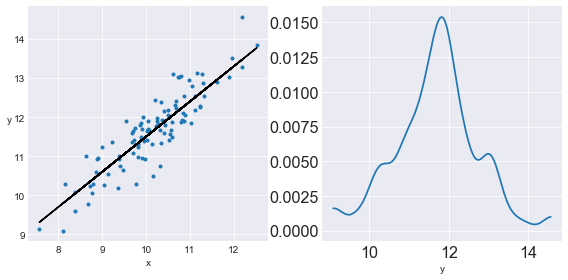

In [11]:
#Data generation
np.random.seed(1)
N = 100
α_real = 2.5
β_real = 0.9
ϵ_real = np.random.normal(0,0.5,size=N)

x = np.random.normal(10,1,N)
y_real = α_real + β_real*x
y = y_real + ϵ_real

_, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(x,y,'C0.')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y', rotation=0)
axes[0].plot(x,y_real,'k')
az.plot_kde(y, ax=axes[1])
axes[1].set_xlabel('y')
plt.tight_layout()
plt.show()

In [7]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α+β*x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|███████████████| 6000/6000 [00:18<00:00, 318.37draws/s]


Note the new object: `Deterministic`. With this we're telling pyMC3 that mu is defined using a formula, not a probablity distribution.

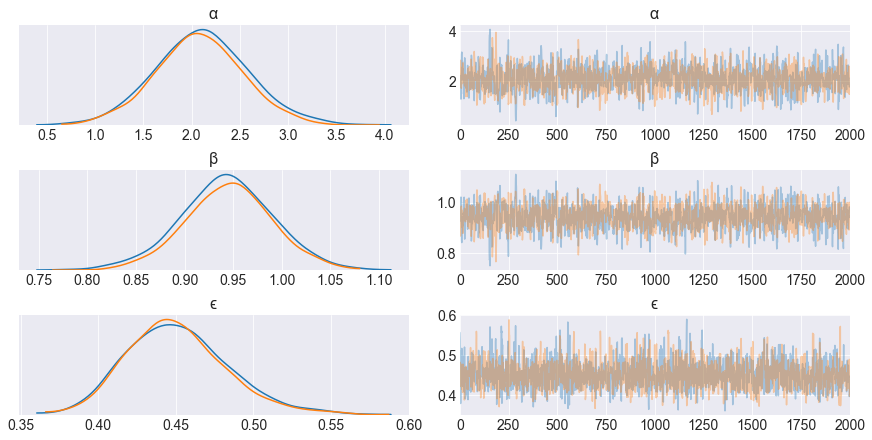

In [12]:
az.plot_trace(trace_g, var_names=['α','β','ϵ'])
plt.show()

### Autocorrelation for linear models

Linear models lead to highly correlated parameter estimates for alpha and beta (see below plot). This is a consequence of our assumptions, that the result is a straight line passing through the center of the data, and changes to parameters 'spin' that line, meaning alpha and beta move in concert. They are _autocorrelated_.

You can mitigate this autocorrelation by normalising x around the mean, $x' = x - \bar{x}$. This has the bonus side effect that your intercept value, y  when x' = 0, is the value of y at the mean of the data, not the arbitrary x=0. More useful. 

Taking this a step further, you can fully standardise the data. This makes things easier for the algorithms, and also means you can use the same weakly informative priors without having to think about the scale of the data.

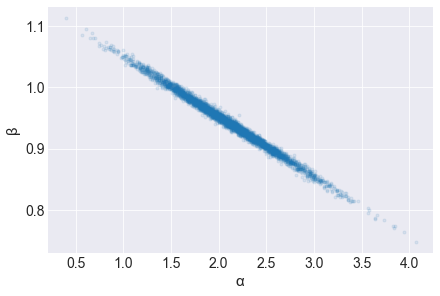

In [15]:
az.plot_pair(trace_g, var_names=['α','β'], plot_kwargs={'alpha':0.1})
plt.show()

### Interpreting the posterior
For LR, you can plot a line over your data with the mean posterior results of alpha and beta, and also plot the sampled lines. Notice that though the range of the sample lines narrows in the middle, they don't all go through a single point.

Alternatively you can plot the HPD as a band. (2nd plot)

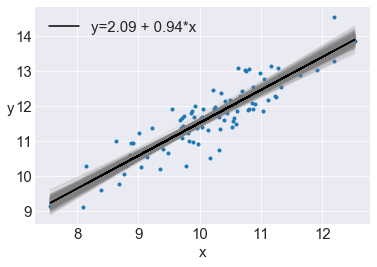

In [27]:
plt.plot(x,y,'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws]+trace_g['β'][draws] 
         * x[:,np.newaxis], c='gray', alpha = 0.1)

plt.plot(x, alpha_m + beta_m * x, c='k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')

plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

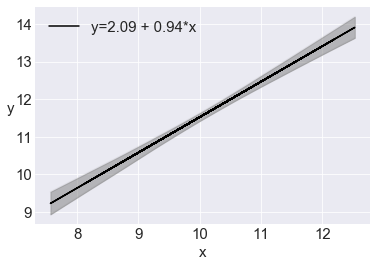

In [38]:
plt.plot(x, alpha_m + beta_m * x, c = 'k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='0.5', plot_kwargs={'alpha':0.1})
plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Another option is to plot the HPD of the posterior predictive.

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 2418.38it/s]


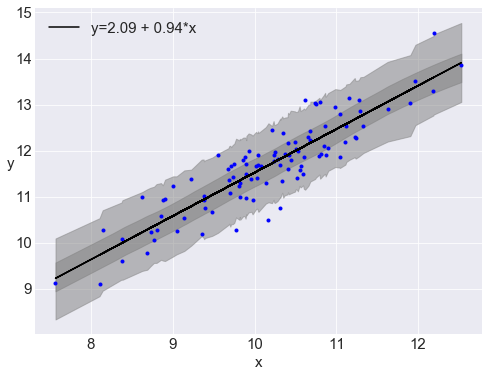

In [51]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)
    
plt.figure(figsize=(8,6))
plt.plot(x,y,'b.')
plt.plot(x, alpha_m + beta_m*x, c='k',
        label = f'y={alpha_m:.2f} + {beta_m:.2f}*x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray')
az.plot_hpd(x, ppc['y_pred'], color='gray', smooth=False) 
# note, plot_hpd is smoothed by default, unsmoothed for illustraion

plt.xlabel('x', fontsize=15)
plt.ylabel('y', rotation=0, fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Correlation coefficient
Pearson is

$$r = \beta \frac{\sigma_x}{\sigma_y}$$

r is between -1 and 1. 0 is no correlation, -1 and 1 are perfect correlations in either direction.

Coefficient of determination (for a linear regression) is $r^2$. 

Using arviz we can get the r2 value and it's SD

In [52]:
az.r2_score(y, ppc['y_pred'])

r2        0.787427
r2_std    0.005695
dtype: float64

## Robust LR

## Hierarchical LR

## Polynomial LR

## Multiple LR

## Interactions

## Variable variance